## 介绍

很久之前写的时钟控件，包含了很多自定义控件的基础，简单分析记录一下。

下面是效果图：

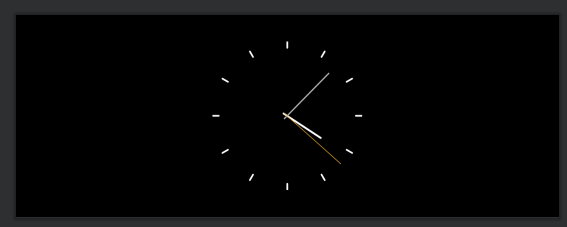

绘制了四个小部分：刻度，时针，分针，秒针。

绘制运用部分很简单，计算相应的角度划线即可，canvas绘制API不多，很快就上手了。



## resolveSize 方法分析

关键部分是onMeasure方法的重写。我看了很多网上的写自定义View的源码，很多在这个方法上逻辑和策略对不上，写的很啰嗦。

Android的View测量流程是自上而下的，子控件必须向父控件传递自身大小的信息。对应于MeasureSpec的设计，我们需写明对应于宽高的mode各3种共3x3=9种的逻辑，看似很多其实只须权衡父布局尺寸限制和本身的大小即可。

让子 View 的计算结果符合父 View 的限制的方法继承的View中已经有实现的方法resolveSize，我们只需给出View的默认大小，通过该方法传入相关参数即可完成尺寸计算。

resolveSize 最终调用 resolveSizeAndState 方法
```java
    public static int resolveSizeAndState(int size, int measureSpec, int childMeasuredState) {
        final int specMode = MeasureSpec.getMode(measureSpec);
        final int specSize = MeasureSpec.getSize(measureSpec);
        final int result;
        switch (specMode) {
            case MeasureSpec.AT_MOST:
                if (specSize < size) {
                    result = specSize | MEASURED_STATE_TOO_SMALL;
                } else {
                    result = size;
                }
                break;
            case MeasureSpec.EXACTLY:
                result = specSize;
                break;
            case MeasureSpec.UNSPECIFIED:
            default:
                result = size;
        }
        return result | (childMeasuredState & MEASURED_STATE_MASK);
    }
```
可以看到其逻辑是在父布局

1. 设置上限时取默认值和上限的最小值
2. 设置特定值时取特定值
3. 无限制时取特定值

resolveSize 其实只是众多策略的一种，当上述策略不符合我们要求时可以参考其重写。

# postInvalidateDelayed 分析

postInvalidateDelayed 方法驱动了时钟的刷新，本质上是通过Hander机制实现。时钟控件这种自刷新的动画可以通过这个方法实现，另外有些控件的动效是和用户交互的，有的通过如触摸等配合Scroller实现，有的可以暴露变量的get/set方法通过属性动画驱动，可以看情况选择。

Android View里很多地方都用到了Handler，实际上Handler机制算得上是Android的核心机制了。

最终调用：
```java
    public void dispatchInvalidateDelayed(View view, long delayMilliseconds) {
        Message msg = mHandler.obtainMessage(MSG_INVALIDATE, view);
        mHandler.sendMessageDelayed(msg, delayMilliseconds);
    }
```
这里的代码没啥好分析的，Android源码里很多带post前缀的基本都会走到类似的代码里，Handler机制在这就不分析了。

附上完整源码：
```java
import android.content.Context;
import android.content.res.Resources;
import android.graphics.Canvas;
import android.graphics.Color;
import android.graphics.Paint;
import android.util.AttributeSet;
import android.util.TypedValue;
import android.view.View;

import java.util.Calendar;

/**
 * by ganxiao
 */
public class ClockView extends View {

    private final int defWidth = 200;
    private final int defHeight = 200;

    // 指针宽度
    private float hWidth = dp2px(3f);
    private float mWidth = dp2px(2f);
    private float sWidth = dp2px(1f);

    // 指针长度
    private float hLen = dp2px(70f);
    private float mLen = dp2px(100f);
    private float sLen = dp2px(120f);

    // 指针过中点长度
    private float endLen = dp2px(6f);

    // 指针颜色
    private int hColor = Color.WHITE;
    private int mColor = Color.parseColor("#B3B3B3");
    private int sColor = Color.parseColor("#F5B32C");

    // 刻度
    private int calColor = Color.WHITE;
    private int calLen = dp2px(10);
    private int calWidth = dp2px(3);

    private Paint mPaint = new Paint(Paint.ANTI_ALIAS_FLAG | Paint.DITHER_FLAG);

    public ClockView(Context context) {
        this(context, null);
    }

    public ClockView(Context context, AttributeSet attrs) {
        this(context, attrs, 0);
    }

    public ClockView(Context context, AttributeSet attrs, int defStyleAttr) {
        super(context, attrs, defStyleAttr);
    }

    @Override
    protected void onMeasure(int widthMeasureSpec, int heightMeasureSpec) {
        setMeasuredDimension(resolveSize(defWidth, widthMeasureSpec), resolveSize(defHeight, heightMeasureSpec));
    }

    @Override
    protected void onDraw(Canvas canvas) {
        drawPointer(canvas);
        postInvalidateDelayed(1000);
    }

    private void drawPointer(Canvas canvas) {
        Calendar calendar = Calendar.getInstance();
        int hour = calendar.get(Calendar.HOUR);
        int minute = calendar.get(Calendar.MINUTE);
        int second = calendar.get(Calendar.SECOND);

        float angleHour = (hour + (float) minute / 60) * 360 / 12;
        float angleMinute = (minute + (float) second / 60) * 360 / 60;
        float angleSecond = second * 360f / 60f;

        // 时针
        canvas.save();
        canvas.rotate(angleHour, getWidth() / 2, getHeight() / 2);
        mPaint.setColor(hColor);
        mPaint.setStyle(Paint.Style.STROKE);
        mPaint.setStrokeCap(Paint.Cap.ROUND);
        mPaint.setStrokeWidth(hWidth);
        canvas.translate(0, endLen);
        canvas.drawLine(getWidth() / 2f, getHeight() / 2f, getWidth() / 2f, getHeight() / 2f - hLen, mPaint);
        canvas.restore();

        // 分针
        canvas.save();
        canvas.rotate(angleMinute, getWidth() / 2, getHeight() / 2);
        mPaint.setColor(mColor);
        mPaint.setStyle(Paint.Style.STROKE);
        mPaint.setStrokeCap(Paint.Cap.ROUND);
        mPaint.setStrokeWidth(mWidth);
        canvas.translate(0, endLen);
        canvas.drawLine(getWidth() / 2f, getHeight() / 2f, getWidth() / 2f, getHeight() / 2f - mLen, mPaint);
        canvas.restore();

        // 秒针
        canvas.save();
        canvas.rotate(angleSecond, getWidth() / 2, getHeight() / 2);
        mPaint.setColor(sColor);
        mPaint.setStyle(Paint.Style.STROKE);
        mPaint.setStrokeCap(Paint.Cap.ROUND);
        mPaint.setStrokeWidth(sWidth);
        canvas.translate(0, endLen);
        canvas.drawLine(getWidth() / 2f, getHeight() / 2f, getWidth() / 2f, getHeight() / 2f - sLen, mPaint);
        canvas.restore();

        canvas.save();
        mPaint.setStrokeWidth(calWidth);
        for (int i = 0; i < 12; i++) {
            mPaint.setColor(calColor);
            canvas.drawLine(getWidth() / 2f, 0, getWidth() / 2f, calLen, mPaint);
            canvas.rotate(30, getWidth() / 2f, getHeight() / 2f);
        }
        canvas.restore();

    }

    public static int dp2px(int dp) {
        return (int) TypedValue.applyDimension(TypedValue.COMPLEX_UNIT_DIP, dp, Resources.getSystem().getDisplayMetrics());
    }

    public static float dp2px(float dp) {
        return TypedValue.applyDimension(TypedValue.COMPLEX_UNIT_DIP, dp, Resources.getSystem().getDisplayMetrics());
    }

}

```